In [1]:
import math
import os
import random
import sys
from copy import copy
from dataclasses import dataclass
import matplotlib.pyplot as plt
import time
import numpy as np
import PIL
from PIL import Image
import base64
from tqdm.notebook import tqdm
import io
from IPython import display

In [2]:
WORLD_SIZE = 100

@dataclass
class Location:
    x: float = 0
    y: float = 0

@dataclass
class Noise:
    movement: float = 0
    turning: float = 0
    sensor: float = 0

@dataclass
class Twist:
    # 2D NonHolonomic
    lin_x: float = 0
    ang_z: float = 0

In [3]:
LANDMARKS = (
    Location(20, 20), Location(20, 80),
    Location(20, 50), Location(50, 20),
    Location(50, 80), Location(80, 80),
    Location(80, 20), Location(80, 50))

In [4]:
def gaussian(mu: float, sigma: float, x: float) -> float:
    var = sigma ** 2
    numerator = math.exp(-((x - mu) ** 2) / (2 * var))
    denom = math.sqrt(2 * math.pi * var)
    return numerator/(denom + sys.float_info.epsilon)

In [5]:
class RobotPose:
    def __init__(self, location: Location = None, heading: float = None, noise: Noise = None) -> None:
        self.location = location if location else Location(random.random()*WORLD_SIZE, random.random()*WORLD_SIZE)
        self.heading = heading if heading else random.random() * math.pi * 2
        self.noise = noise

    def move(self, cmd_vel: Twist) -> None:
        theta = self.heading + cmd_vel.ang_z + random.gauss(0, self.noise.turning)
        theta %= 2 * math.pi # Clamp to 2pi.
        cmd_vel.lin_x += random.gauss(0, self.noise.movement)
        x = self.location.x + math.cos(theta) * cmd_vel.lin_x
        y = self.location.y + math.sin(theta) * cmd_vel.lin_x
        self.location = Location(x % WORLD_SIZE, y % WORLD_SIZE) # clamp to world size
        self.heading = theta

    def sense(self) -> list[float]:
        return [self.euclidian_distance(landmark) + random.gauss(0.0, self.noise.sensor) 
                for landmark in LANDMARKS]

    # Euclidian distance
    def euclidian_distance(self, landmark: Location) -> float:
        return math.sqrt((self.location.x - landmark.x)**2 + (self.location.y - landmark.y)**2)
    
    def __copy__(self) -> 'RobotPose':
        return type(self)(self.location, self.heading, self.noise)
    
    def __str__(self) -> None:
        return f'x({self.location.x}) y({self.location.y}) heading({self.heading})'
    
    def measurement_probability(self, true_measurements: list[float]) -> float:
        prob = 1.0
        for i, landmark in enumerate(LANDMARKS):
            dist = self.euclidian_distance(landmark)
            prob *= gaussian(dist, self.noise.sensor, true_measurements[i]) # how close are we according to gauss
        return prob

In [6]:
# Calculate error for each particle compared to the actual robot position.
# Then return average to get an overview of the overall system
def evaluation(robot: RobotPose, particles: list[RobotPose]):
    sum_ = 0.0
    x, y = robot.location.x, robot.location.y
    for particle in particles:
        dx = (particle.location.x - x + (WORLD_SIZE / 2.)) % WORLD_SIZE - (WORLD_SIZE / 2.)
        dy = (particle.location.y - y + (WORLD_SIZE / 2.)) % WORLD_SIZE - (WORLD_SIZE / 2.)
        err = math.sqrt(dx ** 2 + dy ** 2)
        sum_ += err
    return sum_ / len(particles)

In [35]:
def visualization_fas(robot: RobotPose, step: int, particles: list[RobotPose], particles_resampled: list[RobotPose], score: str) -> PIL.Image:
    fig = plt.figure("Robot in the world", figsize=(5., 5.))
    fig.add_subplot(111)
    plt.clf()
    plt.title(f'Particle filter, step {step:02} Score: {score:.3f}')
    # Draw coordinant grid 
    grid = [0, WORLD_SIZE, 0, WORLD_SIZE]
    plt.axis(grid)
    plt.grid(visible=True, which='major', color='0.75', linestyle='--')
    plt.xticks(range(0, int(WORLD_SIZE), 5))
    plt.yticks(range(0, int(WORLD_SIZE), 5))
    def draw_circle(x_: float, y_: float, face: str, edge: str, alpha: float = 1.) -> None:
        circle = plt.Circle((x_, y_), 1., facecolor=face, edgecolor=edge, alpha=alpha)
        plt.gca().add_patch(circle)
    def draw_arrow(x_: float, y_: float, angle: float, face: str, edge: str, alpha: float = 1.) -> None:
        arrow = plt.Arrow(x_, y_, 2* math.cos(angle), 2*math.sin(angle), facecolor=face, edgecolor=edge, alpha=alpha)
        plt.gca().add_patch(arrow)
    # # draw particles
    plt.scatter([p.location.x for p in particles], [p.location.y for p in particles], facecolor='#ffb266', edgecolors='#994c00')
    # # resampled particles
    plt.scatter([p.location.x for p in particles_resampled], [p.location.y for p in particles_resampled], facecolor='#66ff66', edgecolors='#009900')
    # # draw landmarks
    plt.scatter([landmark.x for landmark in LANDMARKS], [landmark.y for landmark in LANDMARKS], facecolor='#cc0000', edgecolors='#330000')
    draw_circle(robot.location.x, robot.location.y, '#6666ff', '#0000cc')
    draw_arrow(robot.location.x, robot.location.y, robot.heading, '#000000', '#000000', 0.5)
    fig.canvas.draw()
    return PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

In [42]:
# Resample particles. 
def sample_and_clip(sample_size: int, weights: list[float], particles: list[RobotPose], dropout: float = .1) -> list[RobotPose]:
    particles_resampled = []
    # For this we're visualizing the weights as a wheel, and rotating a beta value around that wheel to obtain new samples.
    # this was introduced by Sebastian Thrun on his Particle Filter course.
    index = int(random.random() * sample_size)
    beta = 0.0
    max_weights = max(weights)
    for i in range(sample_size):
        beta += random.random() * 2.0 * max_weights
        while beta > weights[index]:
            beta -= weights[index]
            index = (index + 1) % sample_size
        particles_resampled.append(copy(particles[index]))
    # Clip particles based on dropout. This allows us to maybe get closer with a certain amount
    # of randomly generated particles to replenish the system.
    particles_resampled = particles_resampled[int(len(particles_resampled)*dropout):]
    return particles_resampled

  0%|          | 0/100 [00:00<?, ?it/s]

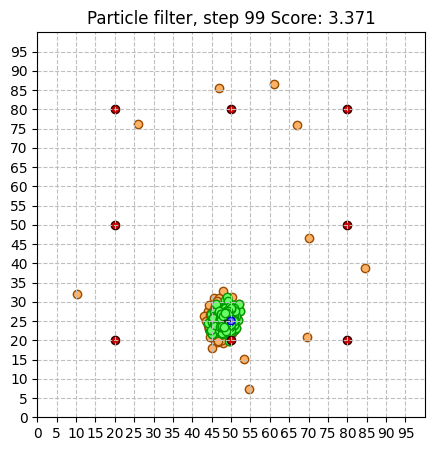

In [91]:
robot = RobotPose(Location(50, 25), math.pi, noise=Noise(0,0,0))
n = 1000 # amount of particles were gunna match against.
particle_noise = Noise(.05, .05, 5)
particles = [RobotPose(noise=particle_noise) for _ in range(n)]

imgs = [] # Images to save plots for gif creation.
steps = 100 # iterations of the system
robot_movement = []
for step in tqdm(range(steps)):
    start_time = time.time()
    # rn = random.random() * math.pi/2 # Random direction rotation
    rn = 0
    if step % 25 == 0:
        rn = -math.pi/2
    elif step % 5 == 0:
        rn = math.pi/2
    cmd_vel = Twist(5, rn) # Movement command for this sim step.
    
    robot.move(cmd_vel)
    meas = robot.sense()
    # robot_movement.append(copy(robot))
    
    # --------------------- MCL ----------------------
    for p in particles:
        p.move(cmd_vel)
        
    # Particle weights, the closer they are to the center
    weights = [p.measurement_probability(meas) for p in particles]
    particles_resampled = sample_and_clip(n, weights, particles, .01)
    evalu = evaluation(robot, particles)
    viz = visualization_fas(robot, step, particles, particles_resampled, evalu)
    imgs.append(viz)
    # reseed (Done to prevent particle deprivation)
    for i in range(n - len(particles_resampled)):
        particles_resampled.append(RobotPose(noise=particle_noise))
    particles = particles_resampled
    # print(f'step {step}, evaluation: {evalu:.3f} Generation time: {time.time()-start_time}')    

In [96]:
### In memory gif generation.
# images is a list of PIL arrays. 
images = imgs
out = io.BytesIO()
images[0].save(out, format='gif', save_all=True, append_images=images[1:], duration=300, loop=0)
display.HTML('<img src="data:image/gif;base64, {0}">'.format(base64.b64encode(out.getvalue()).decode('utf8')))

In [1]:
# # Pseudo code:
# def MCL(prev_particles, move_command, sensor_readout):
#   new_particles = []
#   weights = []
  
#   # motion and sensor update
#   for i = 1 -> len(prev_particles):
#     particle[i].move(move_command)
#     weight = compare_probability(particle[i].sense())
#     weights.append(weight)
  
#   # resampling
#   weights = normalize(weights)
#   for i = 1 -> len(prev_particles):
#     selection = random.choice(prev_particles, probability=weights)
#     new_particles.append(selection)
  
#   return new_particles